In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import unittest
from tqdm import tqdm
import copy

# Задание 1

In [3]:
def nll_func(logits, labels):
    return -torch.mean(labels * torch.log(logits + 1e-7) + (1 - labels) * torch.log(1 - logits + 1e-7))

In [148]:
def grad_desc(features, labels, weights, bias, learning_rate):
    weighted_sum = features @ weights + bias
    output = torch.sigmoid(weighted_sum)

    loss = nll_func(output, labels)

    error = output - labels
    dw = (features.T @ error) / features.shape[0]
    db = torch.mean(error)

    weights -= learning_rate * dw
    bias -= learning_rate * db

    return weights, bias, round(loss.item(), 4)

In [149]:
def mini_batch_grad_desc(features, labels, weights, bias, learning_rate, batch_size=32):
    indices = torch.randperm(features.shape[0])
    features = features[indices]
    labels = labels[indices]

    for i in range(0, features.shape[0], batch_size):
        batch_features = features[i:i + batch_size]
        batch_labels = labels[i:i + batch_size]

        weighted_sum = batch_features @ weights + bias
        output = torch.sigmoid(weighted_sum)

        error = output - batch_labels
        dw = (batch_features.T @ error) / batch_features.shape[0]
        db = torch.mean(error)

        weights -= learning_rate * dw
        bias -= learning_rate * db

    full_output = 1.0 / (1.0 + torch.exp(-(features @ weights + bias)))
    full_loss = nll_func(full_output, labels)

    return weights, bias, round(full_loss.item(), 4)

In [150]:
def modeling_neuron(
    features,
    labels,
    initial_weights,
    initial_bias,
    learning_rate,
    epochs,
    do_mini_batch_grad_desc=False,
    batch_size=64,
):
    features = torch.tensor(features, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32)
    weights = torch.tensor(initial_weights, dtype=torch.float32)
    bias = torch.tensor(initial_bias, dtype=torch.float32)

    loss_history = []
    for _ in range(epochs):
        if do_mini_batch_grad_desc:
            weights, bias, loss = mini_batch_grad_desc(
                features, labels, weights, bias, learning_rate, batch_size
            )
        else:
            weights, bias, loss = grad_desc(
                features, labels, weights, bias, learning_rate
            )
        loss_history.append(loss)
    
    return weights.tolist(), bias.tolist(), loss_history

In [4]:
X = pd.read_csv("/Users/22054483/Downloads/train_x.csv", index_col=0)
y = pd.read_csv("/Users/22054483/Downloads/train_y.csv")

two_year_idxs = y[(y["year"] == 2010) | (y["year"] == 1982)].index

X = X.iloc[two_year_idxs]
y = y.iloc[two_year_idxs]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y["year"])

y_train_binary = (y_train["year"] == 2010).astype(float)
y_test_binary = (y_test["year"] == 2010).astype(float)

X_train

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
442922,46.39274,17.01145,46.00413,5.01020,9.08760,2.63225,1.27898,1.81706,12.71824,3.60866,...,9.30891,78.48034,77.66883,113.13458,9.77663,51.09832,73.80809,7.73413,0.81731,7.49836
313911,41.56446,-73.08405,83.25511,41.37122,-0.11751,14.77119,-7.08551,-11.29124,-3.85986,2.98431,...,37.57704,7.17819,30.62182,40.27806,-23.12810,64.48189,-43.10404,13.27613,47.37565,21.53047
92229,46.26745,-11.13241,41.20084,20.34089,-15.65716,-0.17076,1.49485,-2.27779,10.07921,0.48452,...,55.78592,109.98163,-128.04863,-74.41712,-20.85741,20.38231,88.25522,-28.43780,-12.12139,28.31456
371629,34.45428,64.03824,-12.71779,27.44506,21.14503,2.73469,-13.49258,-8.98753,8.06210,9.16329,...,-25.53989,-248.32853,56.23285,119.16669,-16.79372,173.16870,-60.59429,-2.71788,-119.24415,-6.07901
107550,45.38897,-34.68016,7.17582,-3.45989,30.60418,-15.53088,12.01203,-5.09645,-1.27912,-4.68945,...,-9.30456,-207.79861,39.89108,65.18919,-3.49204,7.08804,-55.14355,4.86392,55.01274,-2.19333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332455,48.80133,83.51979,14.73973,-7.62390,-44.07028,-9.14630,-15.69969,-5.92918,37.78413,11.72715,...,-14.68119,-21.15812,49.05434,47.83213,10.65089,122.51248,100.78349,3.84741,-51.23174,1.78241
415232,47.65603,1.03161,47.30093,4.74715,-28.22190,-15.46413,-1.82385,-9.50023,-7.26316,-6.64410,...,29.23505,61.11040,17.49019,39.72296,32.49855,103.34112,-5.56834,9.35941,76.31196,16.02318
514526,46.42007,-82.46810,50.62122,26.72997,-31.21084,5.28201,39.54801,3.61510,8.48238,-2.53843,...,28.65484,-16.20536,287.60632,-53.78490,-11.81951,297.16872,240.31087,9.03568,262.32831,2.58653
245109,44.32707,3.33766,-2.80026,4.62045,-24.27917,10.03847,7.39431,5.91213,-8.97317,-0.26093,...,-25.95570,-194.63151,-6.49891,277.29869,-11.66141,-51.38779,21.26359,-12.46235,191.13607,0.50354


In [172]:
NUM_EPOCHS = 1000
WEIGHTS_INIT = 0.1
BIAS_INIT = 0
LEARNING_RATE = 0.01

In [173]:
gd_weights, gd_bias, gd_loss_history = modeling_neuron(
    X_train.values,
    y_train_binary.values,
    [WEIGHTS_INIT] * X_train.shape[1],
    BIAS_INIT,
    LEARNING_RATE,
    NUM_EPOCHS,
    do_mini_batch_grad_desc=False,
)

In [174]:
mbgd_weights, mbgd_bias, mbgd_loss_history = modeling_neuron(
    X_train.values,
    y_train_binary.values,
    [WEIGHTS_INIT] * X_train.shape[1],
    BIAS_INIT,
    LEARNING_RATE,
    NUM_EPOCHS,
    do_mini_batch_grad_desc=True,
    batch_size=16,
)

In [183]:
def predict(features, weights, bias):
    features_t = torch.tensor(features, dtype=torch.float32)
    weights_t = torch.tensor(weights, dtype=torch.float32).reshape(-1, 1)
    bias_t = torch.tensor(bias, dtype=torch.float32)

    weighted_sum = features_t @ weights_t + bias_t
    
    probabilities = torch.sigmoid(weighted_sum)
    
    predictions = (probabilities >= 0.5).float().tolist()
    
    return predictions

In [184]:
gd_predictions = predict(X_test.values, gd_weights, gd_bias)
mbgd_predictions = predict(X_test.values, mbgd_weights, mbgd_bias)

print("GD Accuracy:", accuracy_score(gd_predictions, y_test["year"].values))
print("MBGD Accuracy:", accuracy_score(mbgd_predictions, y_test["year"].values))

GD Accuracy: 0.0
MBGD Accuracy: 0.0


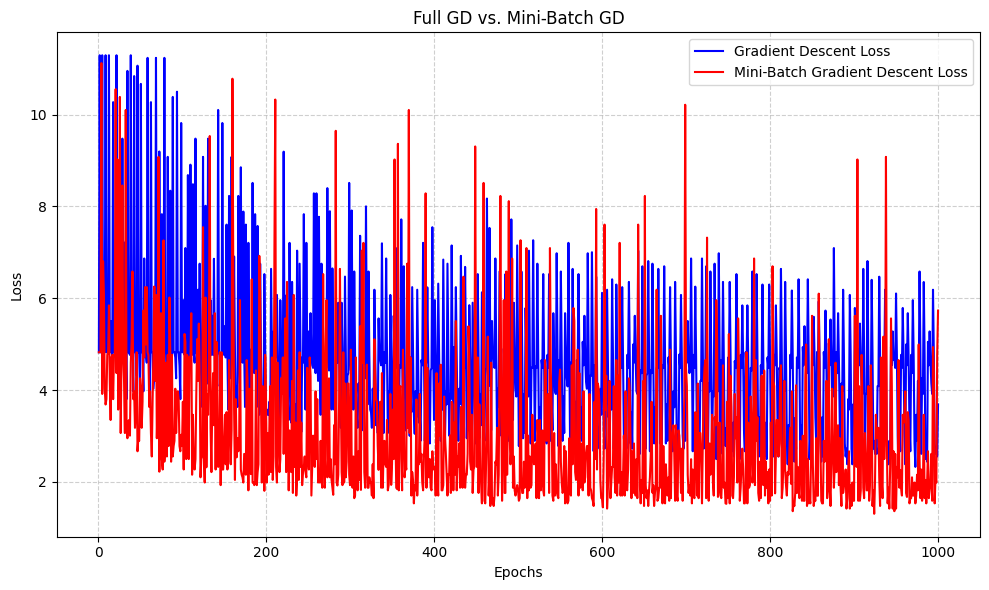

In [177]:
plt.figure(figsize=(10, 6))

epochs_range = list(range(1, NUM_EPOCHS + 1))
plt.plot(epochs_range, gd_loss_history, label='Gradient Descent Loss', color='blue')
plt.plot(epochs_range, mbgd_loss_history, label='Mini-Batch Gradient Descent Loss', color='red')


plt.title('Full GD vs. Mini-Batch GD')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Выводы**: видно, что модель чему-то обучается, но из-за маленького кол-ва данных (284 наблюдения в трейне), и большого кол-ва признаков (90), ей сложно выучить истинную зависимость, и она скорее всего переобучилась (проклятие размерности и тд). Также мы видим по графику, что мини-батч спуск сходится к суб-оптимуму намного быстрее, чем полный спуск, возможно это связано с тем, что градиент получается более шумным (тоже видно на графике), и этот шум помогает быстрее выходить из плато или локальных минимумов, его шумность в данном случае помогает лучше исследовать поверхность функции потерь на кандидатов на оптимум. Также в идеале под каждый метод обучения подбирать свой lr, потому что для gd и mbgd они должны быть разными.

# Задание 2

In [205]:
class Node:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
    
    def __repr__(self):
        return f" Element(data={self.data}, grad={self.grad})"
    
    def __add__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        new_node = Node(self.data + other.data, (self, other), '+')
        new_node._grad = lambda grad: [(self, grad), (other, grad)]
        return new_node
    
    def __radd__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        return other + self
    
    def __mul__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        new_node = Node(self.data * other.data, (self, other), '*')
        new_node._grad = lambda grad: [(self, other.data * grad), (other, self.data * grad)]
        return new_node
    
    def __rmul__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        return other * self
    
    def relu(self):
        new_node = Node(max(0, self.data), (self,), 'relu')
        new_node._grad = lambda grad: [(self, grad if self.data > 0 else 0)]
        return new_node
    
    def backward(self):
        self.grad = 1.0
        stack = [self]
        visited = set()

        while stack:
            node = stack.pop()
            if node in visited:
                continue
            visited.add(node)
            if hasattr(node, "_grad") and node._grad is not None:
                for child, g in node._grad(node.grad):
                    child.grad += g
                    if child not in visited:
                        stack.append(child)

In [206]:
a = Node(2)
b = Node(-3)
c = Node(10)
d = a + b * c
e = d.relu()
e.backward()

print(a, b, c, d, e)

 Element(data=2, grad=0)  Element(data=-3, grad=0)  Element(data=10, grad=0)  Element(data=-28, grad=0)  Element(data=0, grad=1.0)


In [208]:
class Test(unittest.TestCase):
    def test_init(self):
        a = Node(5)
        self.assertEqual(a.data, 5)
        self.assertEqual(a.grad, 0.0)
        self.assertEqual(a._op, '')
        self.assertEqual(len(a._prev), 0)
    
    def test_add_forward_node_node(self):
        a = Node(5)
        b = Node(3)
        c = a + b
        self.assertEqual(c.data, 8)
        self.assertEqual(c._op, '+')
        self.assertEqual(c._prev, {a, b})
    
    def test_add_forward_node_number(self):
        a = Node(5)
        c = a + 3
        self.assertAlmostEqual(c.data, 8)
    
    def test_add_forward_number_node(self):
        b = Node(3.0)
        c = 5 + b
        self.assertAlmostEqual(c.data, 8)
    
    def test_add_backward(self):
        a = Node(2)
        b = Node(3)
        c = a + b
        c.backward()
        self.assertEqual(a.grad, 1.0)
        self.assertEqual(b.grad, 1.0)
    
    def test_mul_forward_node_node(self):
        a = Node(5)
        b = Node(3)
        c = a * b
        self.assertEqual(c.data, 15)
        self.assertEqual(c._op, '*')
        self.assertEqual(c._prev, {a, b})
        
    def test_mul_forward_node_number(self):
        a = Node(5)
        c = a * 3
        self.assertAlmostEqual(c.data, 15)
    
    def test_mul_backward(self):
        a = Node(2)
        b = Node(3)
        c = a * b
        c.backward()
        self.assertEqual(a.grad, 3.0)
        self.assertEqual(b.grad, 2.0)
    
    def test_relu_forward_positive(self):
        a = Node(5)
        b = a.relu()
        self.assertEqual(b.data, 5)
        
    def test_relu_forward_negative(self):
        a = Node(-5)
        b = a.relu()
        self.assertEqual(b.data, 0)

    def test_relu_backward_positive(self):
        a = Node(5)
        b = a.relu()
        b.backward()
        self.assertEqual(a.grad, 1.0)

    def test_relu_backward_negative(self):
        a = Node(-5)
        b = a.relu()
        b.backward()
        self.assertEqual(a.grad, 0.0)
        
    def test_relu_backward_zero(self):
        a = Node(0)
        b = a.relu()
        b.backward()
        self.assertEqual(a.grad, 0.0)
    
    def test_complex_graph_chain_rule(self):
        a = Node(4)
        b = Node(-2)
        
        c = a * b
        d = a.relu()
        
        L = c + d
        
        L.backward()
        
        self.assertAlmostEqual(L.data, -4.0, msg="Forward pass for complex graph failed.")
        self.assertEqual(a.grad, -1.0)
        self.assertEqual(b.grad, 4.0)
        self.assertEqual(c.grad, 1.0)
        self.assertEqual(d.grad, 1.0)

if __name__ == "__main__":
    unittest.main(argv=[''], exit=False)

..............
----------------------------------------------------------------------
Ran 14 tests in 0.011s

OK


# 3

In [47]:
class Neuron(nn.Module):
    def __init__(self, initial_weights, initial_bias):
        super(Neuron, self).__init__()
        w = torch.tensor(initial_weights, dtype=torch.float32).view(-1, 1)
        b = torch.tensor([initial_bias], dtype=torch.float32)
        self.weights = nn.Parameter(w)
        self.bias = nn.Parameter(b)

    def forward(self, features):
        return torch.sigmoid(features @ self.weights + self.bias)


def modeling_neuron_with_optim(
    features,
    labels,
    initial_weights,
    initial_bias,
    epochs,
    optimizer_cls,
):
    features = torch.tensor(features, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32)
    weights = torch.tensor(initial_weights, dtype=torch.float32)
    bias = torch.tensor(initial_bias, dtype=torch.float32)
    
    model = Neuron(weights, bias)
    
    optimizer = optimizer_cls(model.parameters())
    
    loss_history = []

    for _ in range(epochs):
        probs = model(features)
        loss = nll_func(probs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
    
    return model.weights.tolist(), model.bias.tolist(), loss_history

### 3.1 AdamW

Описание: AdamW это улучшенная версия Adam, в нем используется L2-регуляризация (затухание весов, weight decay). В Adam L2-регуляризация неявно добавлялась к градиенту, что некорректно взаимодействовало с адаптивными скоростями обучения (накопленными первыми и вторыми моментами), особенно для параметров с большими накопленными градиентами. AdamW сначала выполняет стандартное адаптивное обновление параметров, и потом применяет затухание весов как не связанный с градиентами этап, уменьшая каждый вес на пропорциональную величину. 

Если более формально, то

$m_t=\beta_1 m_{t-1}+(1-\beta_1)g_t$ - первый момент
$v_t=\beta_2v_{t-1}+(1-\beta_2)g_t^2$ - второй момент

Коррекция смещения

$\hat{m_t}=\frac{m_t}{1-\beta_1^t}$

$\hat{v_t}=\frac{v_t}{1-\beta_2^t}$

Обновление весов + weight decay

$w_t=w_{t-1}-\alpha\frac{\hat{m_t}}{\sqrt{\hat{v_t}}+\varepsilon}-\alpha\lambda w_{t-1}$

In [232]:
class AdamWOptimizer:
    def __init__(
        self,
        initial_weights,
        initial_bias,
        beta1=0.9,
        beta2=0.999,
        eps=1e-7,
        weight_decay=0.01,
        lr=0.001,
    ):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.weight_decay = weight_decay
        
        self.weights = initial_weights.requires_grad_(True)
        self.bias = initial_bias.requires_grad_(True)
        
        self.step = 0
        
        self.m_w = torch.zeros_like(self.weights, requires_grad=False)
        self.v_w = torch.zeros_like(self.weights, requires_grad=False)
        self.m_b = torch.zeros_like(self.bias, requires_grad=False)
        self.v_b = torch.zeros_like(self.bias, requires_grad=False)

    def __call__(self, features, labels):
        self.step += 1
        
        predictions = features @ self.weights + self.bias
        probs = torch.sigmoid(predictions)
        loss = nll_func(probs, labels)

        if self.weights.grad is not None:
            self.weights.grad.zero_()
        if self.bias.grad is not None:
            self.bias.grad.zero_()
            
        loss.backward()

        with torch.no_grad():
            g_w = self.weights.grad
            self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * g_w
            self.v_w = self.beta2 * self.v_w + (1 - self.beta2) * g_w.pow(2)
            
            m_hat_w = self.m_w / (1 - self.beta1**self.step)
            v_hat_w = self.v_w / (1 - self.beta2**self.step)
            
            adam_step_w = self.lr * m_hat_w / (v_hat_w.sqrt() + self.eps)
            
            self.weights -= adam_step_w
            self.weights -= self.lr * self.weight_decay * self.weights
            
            g_b = self.bias.grad
            self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * g_b
            self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * g_b.pow(2)
            
            m_hat_b = self.m_b / (1 - self.beta1**self.step)
            v_hat_b = self.v_b / (1 - self.beta2**self.step)
            
            adam_step_b = self.lr * m_hat_b / (v_hat_b.sqrt() + self.eps)
            
            self.bias -= adam_step_b
            
        return self.weights, self.bias, loss.item()

### 3.2 NAG

In [269]:
class NAGOptimizer:
    def __init__(self, initial_weights, initial_bias, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        
        self.weights = initial_weights.requires_grad_(True)
        self.bias = initial_bias.requires_grad_(True)
        
        self.m_w = torch.zeros_like(self.weights, requires_grad=False)
        self.m_b = torch.zeros_like(self.bias, requires_grad=False)

    def __call__(self, features, labels):
        w_lookahead = self.weights - self.momentum * self.m_w
        b_lookahead = self.bias - self.momentum * self.m_b

        predictions = features @ w_lookahead + b_lookahead
        probs = torch.sigmoid(predictions)
        loss = nll_func(probs, labels)

        if self.weights.grad is not None:
            self.weights.grad.zero_()
        if self.bias.grad is not None:
            self.bias.grad.zero_()
        loss.backward()

        with torch.no_grad():
            self.m_w = self.momentum * self.m_w + self.lr * self.weights.grad
            self.m_b = self.momentum * self.m_b + self.lr * self.bias.grad

            self.weights -= self.m_w
            self.bias -= self.m_b

            self.weights.grad.zero_()
            self.bias.grad.zero_()

        return self.weights, self.bias, loss.item()

### 3.3 Nadam

In [234]:
class NAdamOptimizer:
    def __init__(
        self,
        initial_weights,
        initial_bias,
        psi=1.0,
        weight_decay=0.01,
        beta1=0.9,
        beta2=0.999,
        eps=1e-8,
        lr=0.001,
    ):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.psi = psi
        self.weight_decay = weight_decay
        self.eps = eps
        
        self.weights = initial_weights.requires_grad_(True)
        self.bias = initial_bias.requires_grad_(True)
        
        self.step = 0
        self.m_w = torch.zeros_like(self.weights, requires_grad=False)
        self.v_w = torch.zeros_like(self.weights, requires_grad=False)
        self.m_b = torch.zeros_like(self.bias, requires_grad=False)
        self.v_b = torch.zeros_like(self.bias, requires_grad=False)
        
        self.mu_prod_w = 1.0 
        self.mu_prod_b = 1.0 

    def __call__(self, features, labels):
        self.step += 1
        t = self.step

        with torch.no_grad():
            self.weights -= self.lr * self.weight_decay * self.weights
        
        beta1_t = self.beta1 * (1.0 - 0.5 * (0.96**(t * self.psi)))
        beta1_t_plus_1 = self.beta1 * (1.0 - 0.5 * (0.96**((t + 1) * self.psi)))
        
        P_t_prev_w = self.mu_prod_w
        P_t_w = P_t_prev_w * beta1_t
        P_t_plus_1_w = P_t_w * beta1_t_plus_1

        P_t_prev_b = self.mu_prod_b
        P_t_b = P_t_prev_b * beta1_t
        P_t_plus_1_b = P_t_b * beta1_t_plus_1

        predictions = features @ self.weights + self.bias
        probs = torch.sigmoid(predictions)
        loss = nll_func(probs, labels)
        
        if self.weights.grad is not None: self.weights.grad.zero_()
        if self.bias.grad is not None: self.bias.grad.zero_()
        loss.backward()
        
        with torch.no_grad():
            g_w = self.weights.grad
            
            self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * g_w
            self.v_w = self.beta2 * self.v_w + (1 - self.beta2) * g_w.pow(2)
            
            m_hat_w = (beta1_t_plus_1 * self.m_w / (1.0 - P_t_plus_1_w)) + \
                      ((1.0 - beta1_t) * g_w / (1.0 - P_t_w))
            
            v_hat_w = self.v_w / (1.0 - self.beta2**t)
            self.weights -= self.lr * m_hat_w / (v_hat_w.sqrt() + self.eps)
            self.mu_prod_w = P_t_w

            g_b = self.bias.grad
            
            self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * g_b
            self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * g_b.pow(2)
            m_hat_b = (beta1_t_plus_1 * self.m_b / (1.0 - P_t_plus_1_b)) + \
                      ((1.0 - beta1_t) * g_b / (1.0 - P_t_b))
            v_hat_b = self.v_b / (1.0 - self.beta2**t)
            
            self.bias -= self.lr * m_hat_b / (v_hat_b.sqrt() + self.eps)

            self.mu_prod_b = P_t_b
            
        return self.weights, self.bias, loss.item()

### 3.4 Adam

In [235]:
class AdamOptimizer:
    def __init__(
        self,
        initial_weights,
        initial_bias,
        beta1=0.9, 
        beta2=0.999,
        eps=1e-8,
        lr=0.001,
    ):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        
        self.weights = initial_weights.requires_grad_(True)
        self.bias = initial_bias.requires_grad_(True)
        
        self.step = 0
        self.m_w = torch.zeros_like(self.weights, requires_grad=False)
        self.v_w = torch.zeros_like(self.weights, requires_grad=False)
        self.m_b = torch.zeros_like(self.bias, requires_grad=False)
        self.v_b = torch.zeros_like(self.bias, requires_grad=False)

    def __call__(self, features, labels):
        self.step += 1
        
        predictions = features @ self.weights + self.bias
        probs = torch.sigmoid(predictions)
        loss = nll_func(probs, labels)
        
        if self.weights.grad is not None:
            self.weights.grad.zero_()
        if self.bias.grad is not None:
            self.bias.grad.zero_()
        loss.backward()
        
        with torch.no_grad():
            
            g_w = self.weights.grad
            self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * g_w
            self.v_w = self.beta2 * self.v_w + (1 - self.beta2) * g_w.pow(2)
            
            m_hat_w = self.m_w / (1 - self.beta1**self.step)
            v_hat_w = self.v_w / (1 - self.beta2**self.step)
            
            adam_step_w = self.lr * m_hat_w / (v_hat_w.sqrt() + self.eps)
            
            self.weights -= adam_step_w
            
            g_b = self.bias.grad
            self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * g_b
            self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * g_b.pow(2)
            
            m_hat_b = self.m_b / (1 - self.beta1**self.step)
            v_hat_b = self.v_b / (1 - self.beta2**self.step)
            adam_step_b = self.lr * m_hat_b / (v_hat_b.sqrt() + self.eps)
            self.bias -= adam_step_b
            
        return self.weights, self.bias, loss.item()

### 3.5 RMSProp

In [54]:
class RMSpropOptimizer:
    def __init__(self, params, lr=0.0001, alpha=0.99, eps=1e-8):
        self.params = list(params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps

        self.state = {id(p): torch.zeros_like(p) for p in self.params}

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue

                grad = p.grad
                v = self.state[id(p)]
                v.mul_(self.alpha).add_((1 - self.alpha) * grad.pow(2))
                p.sub_(self.lr * grad / (v.sqrt() + self.eps))

### 3.6 Adadelta

In [237]:
class AdadeltaOptimizer:
    def __init__(self, initial_weights, initial_bias, rho=0.9, eps=1e-6):
        self.rho = rho
        self.eps = eps
        
        self.weights = initial_weights.requires_grad_(True)
        self.bias = initial_bias.requires_grad_(True)
        
        self.Eg2_w = torch.zeros_like(self.weights, requires_grad=False)
        self.Eupdates2_w = torch.zeros_like(self.weights, requires_grad=False)
        self.Eg2_b = torch.zeros_like(self.bias, requires_grad=False)
        self.Eupdates2_b = torch.zeros_like(self.bias, requires_grad=False)

    def __call__(self, features, labels):
        predictions = features @ self.weights + self.bias
        probs = torch.sigmoid(predictions)
        loss = nll_func(probs, labels)
        
        if self.weights.grad is not None:
            self.weights.grad.zero_()
        if self.bias.grad is not None:
            self.bias.grad.zero_()
        loss.backward()
        
        with torch.no_grad():
            g_w = self.weights.grad
            
            self.Eg2_w = self.rho * self.Eg2_w + (1 - self.rho) * g_w.pow(2)

            rms_updates_w = (self.Eupdates2_w + self.eps).sqrt()
            rms_gradients_w = (self.Eg2_w + self.eps).sqrt()
            
            Delta_theta_w = - (rms_updates_w / rms_gradients_w) * g_w
            self.weights += Delta_theta_w
            self.Eupdates2_w = self.rho * self.Eupdates2_w + (1 - self.rho) * Delta_theta_w.pow(2)

            g_b = self.bias.grad
            self.Eg2_b = self.rho * self.Eg2_b + (1 - self.rho) * g_b.pow(2)
            rms_updates_b = (self.Eupdates2_b + self.eps).sqrt()
            rms_gradients_b = (self.Eg2_b + self.eps).sqrt()
            
            Delta_theta_b = - (rms_updates_b / rms_gradients_b) * g_b
            self.bias += Delta_theta_b
            self.Eupdates2_b = self.rho * self.Eupdates2_b + (1 - self.rho) * Delta_theta_b.pow(2)
            
        return self.weights, self.bias, loss.item()

### 3.7 Adagrad

In [60]:
class AdagradOptimizer:
    def __init__(self, params, lr=0.001, eps=1e-8):
        self.params = list(params)
        self.lr = lr
        self.eps = eps
        self.state = {id(p): torch.zeros_like(p) for p in self.params}

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                g = p.grad
                G = self.state[id(p)]
                G.add_(g.pow(2))
                adjusted_step = self.lr * g / (G.sqrt() + self.eps)
                p.sub_(adjusted_step)

### 3.8 Nesterov

### 3.9 Momentum

In [27]:
class MomentumOptimizer:
    def __init__(self, params, lr=1e-3, momentum=0.9):
        self.params = list(params)
        self.lr = lr
        self.momentum = momentum
        self.state = {id(p): torch.zeros_like(p) for p in self.params}

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                v = self.state[id(p)]
                v.mul_(self.momentum).add_(-self.lr, p.grad)
                p.add_(v)

### Running alltogether

In [28]:
NUM_EPOCHS = 1000
WEIGHTS_INIT = 0.01 * torch.randn(X_train.shape[1])
BIAS_INIT = 0

In [48]:
_, _, loss_history_momentum = modeling_neuron_with_optim(
    X_train.values,
    y_train_binary.values,
    WEIGHTS_INIT,
    BIAS_INIT,
    NUM_EPOCHS,
    MomentumOptimizer,
)

/var/folders/9x/62mr6brs5kx49jmg7rc4sl_n7mr_l0/T/ipykernel_79752/3149919067.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(initial_weights, dtype=torch.float32)
/var/folders/9x/62mr6brs5kx49jmg7rc4sl_n7mr_l0/T/ipykernel_79752/3149919067.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(initial_weights, dtype=torch.float32).view(-1, 1)


In [61]:
_, _, loss_history_adagrad = modeling_neuron_with_optim(
    X_train.values,
    y_train_binary.values,
    WEIGHTS_INIT,
    BIAS_INIT,
    NUM_EPOCHS,
    AdagradOptimizer,
)

/var/folders/9x/62mr6brs5kx49jmg7rc4sl_n7mr_l0/T/ipykernel_79752/3149919067.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(initial_weights, dtype=torch.float32)
/var/folders/9x/62mr6brs5kx49jmg7rc4sl_n7mr_l0/T/ipykernel_79752/3149919067.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(initial_weights, dtype=torch.float32).view(-1, 1)


In [55]:
_, _, loss_history_rmsprop = modeling_neuron_with_optim(
    X_train.values,
    y_train_binary.values,
    WEIGHTS_INIT,
    BIAS_INIT,
    NUM_EPOCHS,
    RMSpropOptimizer,
)

/var/folders/9x/62mr6brs5kx49jmg7rc4sl_n7mr_l0/T/ipykernel_79752/3149919067.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(initial_weights, dtype=torch.float32)
/var/folders/9x/62mr6brs5kx49jmg7rc4sl_n7mr_l0/T/ipykernel_79752/3149919067.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(initial_weights, dtype=torch.float32).view(-1, 1)


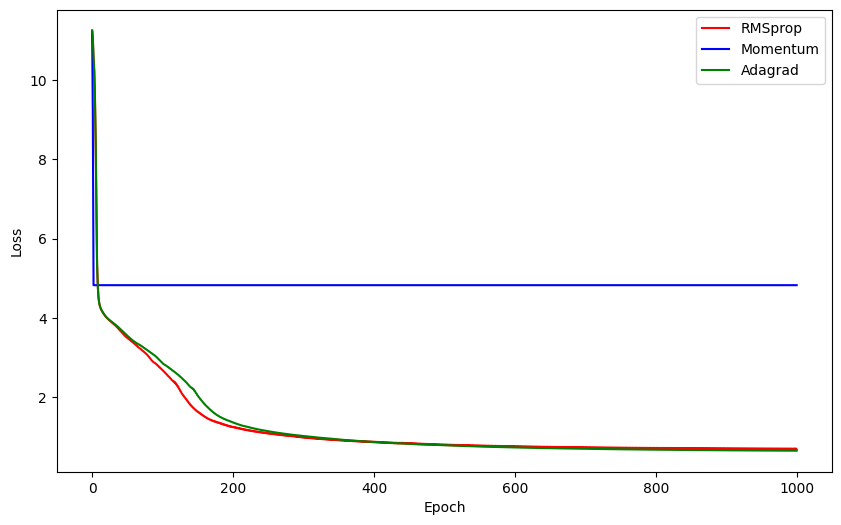

In [62]:
plt.figure(figsize=(10, 6))

plt.plot(loss_history_rmsprop, label='RMSprop', color='red')
plt.plot(loss_history_momentum, label='Momentum', color='blue')
plt.plot(loss_history_adagrad, label='Adagrad', color='green')
    
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 4. 

In [496]:
X = pd.read_csv("/Users/22054483/Downloads/train_x.csv", index_col=0)
y = pd.read_csv("/Users/22054483/Downloads/train_y.csv", index_col=0)["year"]

X_test = pd.read_csv("/Users/22054483/Downloads/test_x.csv")

X

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
133081,37.47518,-14.34414,40.54872,-9.10171,16.77175,-17.77113,-16.50156,-4.09543,2.49723,-0.46428,...,104.03557,-115.62803,-13.79660,31.60436,28.95927,-25.93164,67.64670,-25.76691,-81.90373,-61.48682
111484,48.17393,-7.02208,-30.36086,-2.41924,2.15406,-8.44502,-1.68191,-8.71434,-7.83802,-5.58019,...,11.58664,24.58950,-36.95682,0.73922,-0.06330,53.75838,-81.05330,8.42811,12.08694,-1.91676
448402,36.58141,26.03203,-4.92774,35.71620,8.53080,3.73167,-7.98443,-7.43976,-1.69797,10.75028,...,23.61190,-366.07968,-62.38201,113.48188,4.72741,181.64459,-134.46216,8.50795,94.15573,-8.47276
254414,41.15615,-17.77029,-32.30961,-21.03778,12.80330,-13.48031,-3.14951,-7.62647,-4.48901,-4.29075,...,25.11398,-79.64532,-77.08169,38.88094,28.52025,24.17783,-86.62542,-1.19418,-74.73449,-17.28130
272580,40.54855,78.77563,-23.29877,98.60192,-30.11496,26.94220,-8.87771,-3.23280,-1.04841,31.69655,...,-9.89388,-252.61021,118.93768,-155.87390,51.85666,-365.15815,59.34936,52.47311,99.00695,-10.18840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235730,41.07421,-46.11382,-51.66532,0.37557,25.80398,1.26290,-10.49353,-10.07358,0.32333,-15.67557,...,31.83905,-72.36598,-54.92087,-24.15969,-17.09262,20.75098,-224.49090,-2.98255,-153.93735,-34.11660
322111,34.81509,-13.13082,-29.35437,48.46882,-0.68983,-6.12095,-13.37087,4.50189,4.16561,5.26544,...,14.70074,-319.94394,116.78836,41.62252,-4.45435,52.41625,100.77207,28.40019,8.61761,8.44485
342863,39.71101,-57.06752,40.08736,-7.64027,30.32610,-15.75997,-6.22334,-3.18631,-6.17265,-3.29597,...,-14.39217,108.77959,59.58646,-7.72240,-3.35246,122.60833,-170.61831,-7.42530,-94.67988,0.41165
64560,38.13518,-23.38279,-5.13088,18.32876,60.00752,-11.65138,24.97451,-8.92320,-31.83523,-10.69312,...,6.43782,257.93367,-33.29026,234.07660,9.55665,118.76462,-185.56438,3.25716,-3.88308,-33.33066


(array([1.100e+01, 2.000e+00, 1.400e+01, 6.200e+01, 1.990e+02, 5.160e+02,
        7.740e+02, 1.666e+03, 4.090e+03, 6.666e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

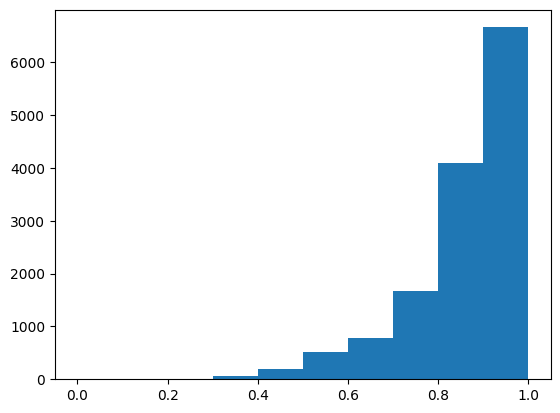

In [468]:
y_min = y.min()
y_max = y.max()

y_scaled = (y - y_min) / (y_max - y_min)

plt.hist(y_scaled)

(array([1.000e+00, 0.000e+00, 2.500e+02, 8.350e+02, 2.053e+03, 2.824e+03,
        3.756e+03, 2.703e+03, 1.417e+03, 1.610e+02]),
 array([-9.21034037, -8.59860601, -7.98687165, -7.37513729, -6.76340293,
        -6.15166856, -5.5399342 , -4.92819984, -4.31646548, -3.70473112,
        -3.09299676]),
 <BarContainer object of 10 artists>)

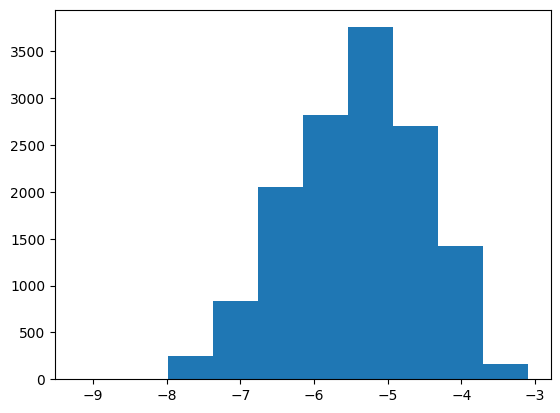

In [485]:
y_min = y.min()
y_max = y.max()

y_scaled = (y - y_min + 1e-4) / (y_max - y_min)

y_inv_log = -np.log(y)
c = min(y_inv_log)

y_scaled_log = np.log(y_inv_log - c + 1e-4)

plt.hist(y_scaled_log)

(array([1.100e+01, 2.000e+00, 1.400e+01, 6.200e+01, 1.990e+02, 5.160e+02,
        7.740e+02, 1.666e+03, 4.090e+03, 6.666e+03]),
 array([1921.80780961, 1930.70691965, 1939.6060297 , 1948.50513974,
        1957.40424979, 1966.30335983, 1975.20246988, 1984.10157992,
        1993.00068997, 2001.89980001, 2010.79891005]),
 <BarContainer object of 10 artists>)

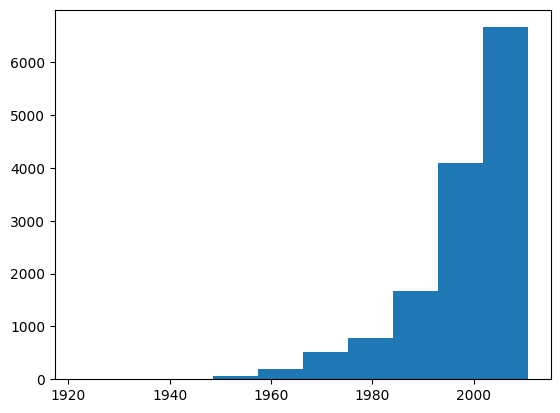

In [484]:
y_scaled_exp = np.exp(y_scaled_log)
y_scaled_exp += c
y_true = np.exp(y_scaled_exp * -1)

plt.hist(y_true)

In [386]:
y_min, y_max

(np.int64(1922), np.int64(2011))

In [497]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

ids = X_test["id"]
X_test = X_test.drop("id", axis=1)
X_test = scaler.transform(X_test)

# y = y["year"].values

X_train, X_val, y_train, y_val = train_test_split(X, y_scaled.values, test_size=0.2, random_state=42)

X_train

array([[ 1.15594061,  0.15479657,  0.28179343, ..., -0.05619979,
         0.25114088, -0.241435  ],
       [ 0.49935462,  0.98874672,  1.8296293 , ..., -0.07079851,
        -0.97278368, -1.21078987],
       [-0.10449318,  0.43890723,  0.17136452, ...,  3.43529004,
        -0.28171642,  1.2811669 ],
       ...,
       [-0.85925107,  0.76941836, -0.18471229, ...,  1.05170791,
         0.28562762,  0.13834472],
       [-1.46260005, -2.62951012,  1.92349752, ...,  0.15615326,
         2.94541916,  2.76021078],
       [-2.47490175, -0.55361228, -2.24027681, ..., -0.17192265,
        -0.02311523,  0.95662918]])

In [498]:
class SimpleNet(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(128, 64)
        # self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc22 = nn.Linear(64, 64)
        # self.bn2 = nn.BatchNorm1d(64)
        self.dropout22 = nn.Dropout(0.3)
        
        self.fc222 = nn.Linear(64, 64)
        # self.bn2 = nn.BatchNorm1d(64)
        self.dropout222 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(64, 32)
        # self.bn3 = nn.BatchNorm1d(32)
        # self.dropout3 = nn.Dropout(0.2)
        
        self.out = nn.Linear(32, 1)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc22(x))
        x = self.dropout22(x)
        x = F.relu(self.fc222(x))
        x = self.dropout222(x)
        x = F.relu(self.fc3(x))
        # x = self.dropout3(x)
        x = self.out(x)
        return x

In [499]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [500]:
model = SimpleNet(X_train.shape[1])

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

loss_func = nn.MSELoss()

In [502]:
epochs = 1000
best_val_loss = float('inf')
best_model_weights = None
val_history = []
train_history = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_func(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)
    train_history.append(train_loss)
    
    scheduler.step(train_loss)
    
    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = loss_func(pred, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)
    val_history.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = copy.deepcopy(model.state_dict())
            
    print(f"Val Loss: {val_loss:.4f} ({val_loss * (y_max - y_min)**2:.2f})")


Epoch 1/1000
Train Loss: 0.0098
Val Loss: 0.0103 (81.53)

Epoch 2/1000
Train Loss: 0.0097
Val Loss: 0.0104 (81.99)

Epoch 3/1000
Train Loss: 0.0095
Val Loss: 0.0103 (81.43)

Epoch 4/1000
Train Loss: 0.0096
Val Loss: 0.0103 (81.54)

Epoch 5/1000
Train Loss: 0.0097
Val Loss: 0.0103 (81.67)

Epoch 6/1000
Train Loss: 0.0095
Val Loss: 0.0103 (81.27)

Epoch 7/1000
Train Loss: 0.0094
Val Loss: 0.0103 (81.39)

Epoch 8/1000
Train Loss: 0.0093
Val Loss: 0.0104 (82.02)

Epoch 9/1000
Train Loss: 0.0093
Val Loss: 0.0103 (81.93)

Epoch 10/1000
Train Loss: 0.0094
Val Loss: 0.0104 (82.07)

Epoch 11/1000
Train Loss: 0.0093
Val Loss: 0.0103 (81.86)

Epoch 12/1000
Train Loss: 0.0094
Val Loss: 0.0104 (82.09)

Epoch 13/1000
Train Loss: 0.0093
Val Loss: 0.0103 (81.77)

Epoch 14/1000
Train Loss: 0.0093
Val Loss: 0.0104 (82.05)

Epoch 15/1000
Train Loss: 0.0093
Val Loss: 0.0104 (82.52)

Epoch 16/1000
Train Loss: 0.0093
Val Loss: 0.0104 (82.69)

Epoch 17/1000
Train Loss: 0.0092
Val Loss: 0.0104 (82.20)

Epoch

: 

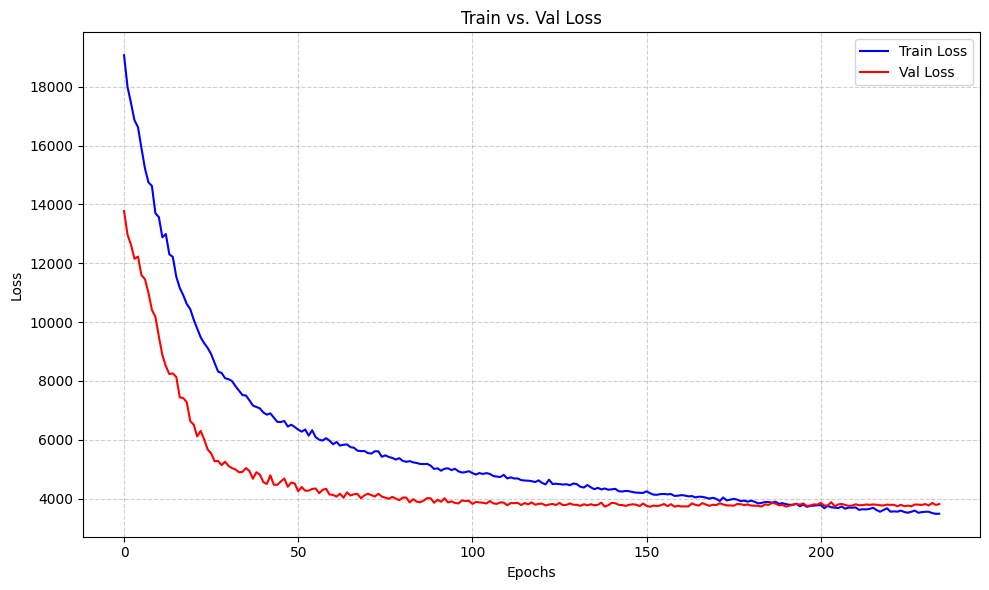

In [492]:
plt.figure(figsize=(10, 6))

plt.plot(np.array(train_history[10:]) * (y_max - y_min)**2, label='Train Loss', color='blue')
plt.plot(np.array(val_history[10:]) * (y_max - y_min)**2, label='Val Loss', color='red')

plt.title('Train vs. Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [452]:
best_model = SimpleNet(input_dim=X_train.shape[1])
best_model.load_state_dict(best_model_weights)
best_model.eval()

with torch.no_grad():
    preds = best_model(X_test_tensor).detach().to("cpu").flatten().tolist()
    preds = [y_min + (y_max - y_min) * p for p in preds]

In [453]:
submission = pd.DataFrame({"id": ids, "year": preds})
submission.to_csv("submission.csv", index=False)

In [ ]:
# write catboost training code for my data
